In [1]:
!pip install datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
# 1. Upgrade bitsandbytes first
!pip install -U bitsandbytes

# 2. Then install other packages
!pip install -q transformers torch accelerate peft rouge-score sentencepiece evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [1]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    MODEL_NAME = "microsoft/phi-2"
    DATASET_NAME = "EdinburghNLP/xsum"

    TRAIN_SAMPLES = 1_000
    VAL_SAMPLES = 50
    TEST_SAMPLES = 50

    MAX_LENGTH = 256

    EPOCHS = 2
    BATCH_SIZE = 1
    GRAD_ACCUMULATION = 16
    LR = 2e-4
    WARMUP_STEPS = 30
    SEED = 42

    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05

    MAX_NEW_TOKENS = 40
    NUM_BEAMS = 2
    TEMPERATURE = 0.7
    TOP_P = 0.9
    REPETITION_PENALTY = 1.2

    OUTPUT_DIR = "./fine-tuned-phi2-summarization"
    RESULTS_DIR = "./results_phi2"

# =============================================================================
# IMPORTS
# =============================================================================
import os
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

========== EDA: XSum ==========
           doc_len      sum_len
count  1000.000000  1000.000000
mean    371.958000    20.987000
std     294.792926     5.426996
min       0.000000     4.000000
25%     175.750000    17.000000
50%     294.000000    21.000000
75%     494.250000    24.000000
max    3487.000000    52.000000


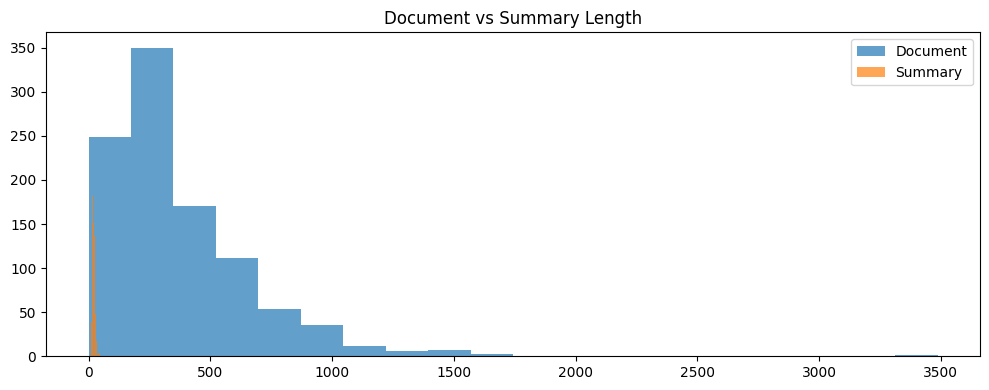

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,2.270929
2,No log,2.258836



Evaluating on test set...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



ROUGE Scores:
rouge1: 0.2796
rouge2: 0.0785
rougeL: 0.2048
rougeLsum: 0.2044

Model saved to ./fine-tuned-phi2-summarization

Document: Sarah Johnson was one of 21 women heading to Liverpool when their minibus was hit by a lorry on the M62.
Her friend Bethany Jones, 18, was killed while Ms Johnson and several others were badly hurt.
M ...
Reference: A woman who was seriously hurt in a fatal hen party motorway crash is now helping other major trauma victims rebuild their lives.
Generated: A woman who survived a bus crash that killed her friend has set up a charity to help other victims. Sarah Johnson, 21, was one of 21 women heading to Liverpool when their minibus was hit

Document: A total of 1,400 tickets have sold out for the opening weekend at Bramall Hall in Stockport, Greater Manchester after renovation work began in 2014.
Stained glass windows and ceilings have been restor ...
Reference: A Tudor manor house has reopened following a £2.2m makeover.
Generated: The historic Bramall

In [2]:
# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def clean_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


def print_device_info():
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data():
    dataset = load_dataset(Config.DATASET_NAME)

    return DatasetDict({
        "train": dataset["train"].shuffle(seed=Config.SEED).select(range(Config.TRAIN_SAMPLES)),
        "validation": dataset["validation"].shuffle(seed=Config.SEED).select(range(Config.VAL_SAMPLES)),
        "test": dataset["test"].shuffle(seed=Config.SEED).select(range(Config.TEST_SAMPLES)),
    })

# =============================================================================
# EDA
# =============================================================================
def run_eda(dataset):
    print("\n========== EDA: XSum ==========")
    df = dataset["train"].to_pandas()

    df["doc_len"] = df["document"].str.split().str.len()
    df["sum_len"] = df["summary"].str.split().str.len()

    print(df[["doc_len", "sum_len"]].describe())

    plt.figure(figsize=(10, 4))
    plt.hist(df["doc_len"], bins=20, alpha=0.7, label="Document")
    plt.hist(df["sum_len"], bins=20, alpha=0.7, label="Summary")
    plt.legend()
    plt.title("Document vs Summary Length")
    plt.tight_layout()
    plt.show()

    del df
    clean_memory()

# =============================================================================
# TOKENIZATION
# =============================================================================
def build_prompt(document, summary=None):
    document = " ".join(document.split()[:150])

    prompt = f"""Summarize the following article in one sentence.

Article:
{document}

Summary:"""

    if summary:
        prompt += " " + summary

    return prompt


def tokenize_dataset(dataset, tokenizer):
    def tokenize_fn(batch):
        prompts = [
            build_prompt(d, s)
            for d, s in zip(batch["document"], batch["summary"])
        ]

        tokens = tokenizer(
            prompts,
            truncation=True,
            padding="max_length",
            max_length=Config.MAX_LENGTH,
        )
        tokens["labels"] = tokens["input_ids"].copy()
        return tokens

    tokenized = dataset.map(
        tokenize_fn,
        batched=True,
        remove_columns=dataset["train"].column_names,
    )

    tokenized.set_format("torch")
    return tokenized

# =============================================================================
# MODEL
# =============================================================================
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    model = AutoModelForCausalLM.from_pretrained(
        Config.MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.float16,
        trust_remote_code=True,
    )

    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=Config.LORA_R,
        lora_alpha=Config.LORA_ALPHA,
        lora_dropout=Config.LORA_DROPOUT,
        target_modules=["q_proj", "v_proj"],
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(model, lora_config)
    model.gradient_checkpointing_enable()
    model.config.use_cache = False

    return tokenizer, model

# =============================================================================
# METRICS
# =============================================================================
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds, tokenizer):
    preds, labels = eval_preds
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds = [p.split("Summary:")[-1].strip() for p in decoded_preds]
    refs = [r.split("Summary:")[-1].strip() for r in decoded_labels]

    return rouge.compute(predictions=preds, references=refs)

# =============================================================================
# TRAINING
# =============================================================================
def train_model(model, tokenizer, tokenized):
    args = TrainingArguments(
        output_dir=Config.RESULTS_DIR,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        gradient_accumulation_steps=Config.GRAD_ACCUMULATION,
        learning_rate=Config.LR,
        warmup_steps=Config.WARMUP_STEPS,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        fp16=True,
        optim="adamw_8bit",
        report_to="none",
        seed=Config.SEED,
    )

    collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        data_collator=collator,
    )

    trainer.train()
    return trainer

def evaluate_model(model, tokenizer, dataset):
    rouge = evaluate.load("rouge")

    predictions = []
    references = []

    for sample in dataset:
        summary = generate_summary(sample["document"], model, tokenizer)
        predictions.append(summary)
        references.append(sample["summary"])

    scores = rouge.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )

    print("\nROUGE Scores:")
    for k, v in scores.items():
        print(f"{k}: {v:.4f}")

    return scores

# =============================================================================
# INFERENCE
# =============================================================================
def generate_summary(document, model, tokenizer):
    prompt = build_prompt(document)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=Config.MAX_NEW_TOKENS,
            num_beams=Config.NUM_BEAMS,
            temperature=Config.TEMPERATURE,
            top_p=Config.TOP_P,
            repetition_penalty=Config.REPETITION_PENALTY,
            pad_token_id=tokenizer.pad_token_id,
        )

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text.split("Summary:")[-1].strip()

# =============================================================================
# MAIN PIPELINE
# =============================================================================
def main():
    set_seed(Config.SEED)
    print_device_info()

    dataset = load_data()
    run_eda(dataset)

    tokenizer, model = load_model()
    tokenized = tokenize_dataset(dataset, tokenizer)

    trainer = train_model(model, tokenizer, tokenized)

    print("\nEvaluating on test set...")
    rouge_scores = evaluate_model(model, tokenizer, dataset["test"])

    model.save_pretrained(Config.OUTPUT_DIR)
    tokenizer.save_pretrained(Config.OUTPUT_DIR)
    print(f"\nModel saved to {Config.OUTPUT_DIR}")

    for i in range(3):
        sample = dataset["test"][i]
        print("\nDocument:", sample["document"][:200], "...")
        print("Reference:", sample["summary"])
        print("Generated:", generate_summary(sample["document"], model, tokenizer))

# =============================================================================
# RUN
# =============================================================================
main()